# W7 Lab Exercise
This is the lab exercise for MIS590: Information Retrieval. </br>
In this lab, you will gain the following experience:</br>
- Understand how to fine-tune a pre-trained BERT model for a specific task using a sample dataset.
- Apply the fine-tuned BERT model to rank documents based on their relevance to a given query.
- Evaluate model performance of the fine-tuned model by comparing its output with expected relevance results.
</br>

**Note:** When you see a pencil icon ✏️ in this notebook, it's time for you to code or answer the question!

# 1. Preliminaries

## 1.1 Install and Import Libraries

In [3]:
# Install necessary libraries
!pip install transformers datasets torch
!pip install pytrec_eval
!pip install bertviz

  Preparing metadata (setup.py) ... done
  Created wheel for pytrec_eval: filename=pytrec_eval-0.5-cp312-cp312-linux_x86_64.whl size=309351 sha256=0039863127a08a1927dc7cad524e03ed183634d50c9a6c564612403c7e7dd087
  Stored in directory: /root/.cache/pip/wheels/c6/4a/9e/e17f9ea004e1c221bd0ff384732285211c4917b790d598ea51
Successfully built pytrec_eval
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.5 MB/s eta 0:00:00


In [4]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel
from datasets import Dataset
import random
import pytrec_eval
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from bertviz import head_view

Make sure you are using GPU!

In [5]:
# Check if GPU is loaded
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and selected as the device.")
else:
    device = torch.device("cpu")
    print("GPU not found, using CPU instead.")

GPU is available and selected as the device.


## 1.2 Input: Query & Document Collections (Corpus)

In [6]:
query = "sleep deprivation"
corpus = [
   "Sleepless nights in the lab have become my new normal. I tried to fix the experiment setup, but the apparatus seems to have a mind of its own. My advisor says results are just around the corner, but the corner keeps moving. Coffee is my only true companion these days.",
    "I thought grad school would be intellectually stimulating, but it's mostly paperwork and waiting for emails. The departmental printer jammed again, and now I'm late for a meeting. The cafeteria ran out of the good snacks, so I'm surviving on vending machine chips. Sleep has become a luxury I can no longer afford.",
    "Writing the dissertation feels like climbing an endless mountain. Every time I finish a chapter, my supervisor suggests new revisions. The impostor syndrome is real, and I wonder if they made a mistake accepting me. Maybe I should have gone to clown college instead. I am utterly deprived of any semblance of a normal life.",
    "My research data got corrupted, and now I have to start over. The lab mouse escaped, and we spent hours trying to find it. The grant proposal deadline is tomorrow, and the online submission portal is down. At least my pet cactus hasn't died yet.",
    "The group meeting turned into a three-hour debate over font choices for the presentation. I'm pretty sure my colleague is stealing my lunch from the fridge. The photocopier is out to get me; it never works when I'm in a hurry. Is there a PhD in napping? Because I'd ace that.",
    "I haven't seen the sun in days due to endless coding sessions. The simulation keeps crashing, and Stack Overflow doesn't have the answers. My roommate thinks I'm a ghost haunting the apartment. Instant noodles have become my primary food group.",
    "Attending conferences sounded fun until I realized they involve a lot of awkward networking. I accidentally spilled coffee on a famous professor's shoes. My poster fell down twice during the session. Next time, I'll just send a cardboard cutout of myself.",
    "The university gym membership was supposed to keep me healthy, but I've only used it once. I tried to attend a yoga class after staying up late for a deadline, but I fell asleep during the meditation. Maybe instead of the gym, my bed is more essential for keeping me healthy.",
    "My teaching assistantship involves grading endless stacks of exams. Students keep emailing me for extensions with creative excuses. One claimed their dog sleeps on the laptop so they cannot use it for the exam. I was deprived of excuses for not completing my dissertation draft, and I might have got some good ones.",
    "Group projects are the worst when you're the only one doing the work. My team members are as elusive as Bigfoot. The project is due next week, and I haven't heard from them. Perhaps I should just write a paper on the sociological implications of group work avoidance."
]

# Binary labels for the documents' relevancy to the query
# Relevant ones: 1, 2, 5, 6, 8
example_labels = [1, 1, 0, 0, 1, 1, 0, 1, 0, 0]

# 2. IR with Pretrained BERT

## 2.1 Load Pre-trained BERT Model

In [7]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2, output_hidden_states=True)

# Move model to GPU
model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### ✏️ Observe the results above and discuss the following:
- In our last lab exercise, we load the BERT model using the following line of code: <br />
`model = BertModel.from_pretrained(model_name)` <br />
However, this time we load BERT using `BertForSequenceClassification`. Can you tell the differences between them? You should be able to see what components are in a BertForSequenceClassification model above.

BertForSequenceClassification builds directly on the core BertModel we used earlier in the course.

The base BertModel still serves as the shared encoder that produces contextual token embeddings, including the informative [CLS] representation.

BertForSequenceClassification then adds the dropout and linear classification head after the encoder so the model can map that pooled representation to a label. Recognizing this layered structure gives me confidence that I am configuring the network correctly for the relevance prediction assignment.

In [8]:
# Function to generate BERT embeddings for a given text
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Move inputs to GPU
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Forward
    with torch.no_grad():
        outputs = model(**inputs)

    # Access the last hidden state and the embedding for the [CLS] token
    return outputs.hidden_states[-1][:, 0, :]

## 2.2 Compute BERT Embeddings

In [9]:
# Compute BERT embeddings for the query
query_embedding = get_bert_embedding(query)

# Compute BERT embeddings for each document in the corpus
corpus_embeddings = [get_bert_embedding(doc) for doc in corpus]

### Measuring similarity: cosine similarity

In [10]:
# Function to compute cosine similarity between two vectors
def cosine_similarity(vec1, vec2):
    vec1 = vec1.numpy()
    vec2 = vec2.numpy()
    dot_product = np.dot(vec1, vec2.T)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    if norm1 == 0 or norm2 == 0:
        return 0.0
    return dot_product / (norm1 * norm2)

### Rank the documents using cosine similarity

In [11]:
# Rank documents based on similarity to the query
rankings_BERT = []

for idx, doc_embedding in enumerate(corpus_embeddings):
    # Move the embeddings back to cpu so we can compute their cosine similarity
    score = cosine_similarity(query_embedding[0].cpu(), doc_embedding[0].cpu())
    rankings_BERT.append((idx + 1, score))

# Sort documents by similarity score in descending order
rankings_BERT_srt = sorted(rankings_BERT, key=lambda x: x[1], reverse=True)

# Print document rankings
print("Document Rankings based on BERT embeddings:")
for rank, (doc_idx, score) in enumerate(rankings_BERT_srt, start=1):
    print(f"Rank {rank}: Document {doc_idx} with score {score}")

Document Rankings based on BERT embeddings:
Rank 1: Document 2 with score 0.8103366494178772
Rank 2: Document 6 with score 0.7880859971046448
Rank 3: Document 5 with score 0.786492645740509
Rank 4: Document 3 with score 0.7857746481895447
Rank 5: Document 1 with score 0.7844796180725098
Rank 6: Document 10 with score 0.7754189968109131
Rank 7: Document 7 with score 0.7519576549530029
Rank 8: Document 8 with score 0.7409096956253052
Rank 9: Document 4 with score 0.7397839426994324
Rank 10: Document 9 with score 0.7047694325447083


## 2.3 Measure Performance

### Average Precision

In [12]:
# Compute Average Precision (AP) using pytrec_eval package

# Define relevance judgments. These are the documents that are actually relevant to the query
qrel = {
    'q1': {
        'doc1': 1,
        'doc2': 1,
        'doc5': 1,
        'doc6': 1,
        'doc8': 1
    }
}

# Define retrieval results with scores, ensuring scores are native Python floats, not numpy floats
q1 = {"doc"+str(i+1): float(rankings_BERT[i][1]) for i in range(0,10)}

# Define retrieval results with scores
run = {
    'q1': q1
}

evaluator = pytrec_eval.RelevanceEvaluator(qrel, {'map'})
results = evaluator.evaluate(run)
print(f"Average Precision (pytrec_eval): {results['q1']['map']:.4f}")

Average Precision (pytrec_eval): 0.8850


### ✏️ Observe the results above and discuss the following:
- What is the difference between this AP score and that computed by sklearn.metric.average_precision_score?

The key difference lies in their purpose. pytrec_eval's Average Precision is an Information Retrieval metric specifically designed to evaluate the ranking of documents based on relevance judgments. sklearn.metrics.average_precision_score, on the other hand, is a general machine learning metric that calculates the area under the precision-recall curve, typically used for evaluating binary classifiers based on predicted probabilities. While related, pytrec_eval's AP is the standard for evaluating ranked lists in IR.

# 3. IR with Fine-Tuned BERT



## 3.1 Load the corpus for fine-tuning

### We will be using two different datasets during the fine-tuning process

*   **Training dataset:** For tuning the parameters of BERT.
*   **Evaluation dataset:** For choosing the best fine-tuned model.

**✏️ Upload Corpus.tsv and Eval.tsv**


In [13]:
# Load training corpus and label
corpus_FT = []
labels = []

with open("./Corpus.tsv", "r") as f:
    for line in f.readlines():
      parts = line.strip().split("\t")

      if len(parts) == 2:
          corpus_FT.append(parts[0])
          labels.append(int(parts[1]))

In [14]:
# Load eval dataset
eval_corpus = []
eval_labels = []

with open("./Eval.tsv", "r") as f:
    for line in f.readlines():
      parts = line.strip().split("\t")

      if len(parts) == 2:
          eval_corpus.append(parts[0])
          eval_labels.append(int(parts[1]))

### ✏️ Observe the results above and discuss the following:
- How many instances are there in the training set?
- How many are there in the evaluation set?
- Why is one of the dataset significantly larger than another?

There are 128 examples in the Corpus.tsv and 20 in the Eval.tsv.
That's because the training set needs to be large enough for the model to learn the patterns for relevance classification. The evaluation set is smaller because its purpose is just to monitor the training process and help select the best performing model during fine-tuning. Having a larger training set provides more diverse examples for the model to learn from, leading to better generalization, while a smaller, representative evaluation set is sufficient for periodic performance checks.

In [15]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

# Prepare dataset
data = {'text': corpus_FT, 'label': labels}
dataset = Dataset.from_dict(data)
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Prepare evaluation dataset
eval_data = {'text': eval_corpus, 'label': eval_labels}
eval_dataset = Dataset.from_dict(eval_data)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/127 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

## 3.2 Fine-Tune BERT

In [16]:
# Fine-Tune BERT

eval_step = 10

# Set up the arguements for fine-tuning
training_args = TrainingArguments(
    output_dir='./results', # Output directory
    num_train_epochs=3, # Number of training epochs
    per_device_train_batch_size=4, # Batch size for training
    per_device_eval_batch_size=8, # Batch size for evaluation
    warmup_steps=10, # Number of warmup steps
    weight_decay=0.01, # We will assign the gradient smaller and smaller weights as the training goes
    logging_dir='./logs', # Log directory
    logging_steps=eval_step, # Log every eval_steps
    eval_strategy="steps", # Evaluate every eval_steps
    eval_steps=eval_step,  # Evaluate every 10 steps
    save_strategy="steps", # Save every eval_steps
    save_steps=eval_step, # Save every 10 steps
    load_best_model_at_end=True, # Load the best model at the end of training
    metric_for_best_model="loss", # Definition of the best model: lowest eval loss
    report_to="none" # Avoid the need to login to Weight & Bias
)

# Initialize the trainer
trainer = Trainer(
    model=model, # Model to be fine-tuned
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_eval_dataset
)

# Start the fine-tuning process
trainer.train()

Step,Training Loss,Validation Loss
10,0.635900,0.654110
20,0.530400,0.317146
30,0.426600,0.198686
40,0.147100,0.169332
50,0.090600,0.258334
60,0.107300,0.260350
70,0.009600,0.257991
80,0.025100,0.151380
90,0.006800,0.013566


TrainOutput(global_step=96, training_loss=0.2073284819877396, metrics={'train_runtime': 139.5958, 'train_samples_per_second': 2.729, 'train_steps_per_second': 0.688, 'total_flos': 100245312092160.0, 'train_loss': 0.2073284819877396, 'epoch': 3.0})

### ✏️ Observe the results above and discuss the following:
- What do the outputs indicate?
- Why are there 96 training steps in total?
- How do the different arguments affect the fine-tuning process?
- Explore the content of the `./results` directory. There are 10 models named `./results/checkpoint-xx`. Why are they generated? Why do we want to save these intermediate models instead of just using the final one (i.e., `./results/checkpoint-96`)?
- Explore the content of the `./logs` directory. What information has been recorded?

The summary of the training shows how many total steps the model ran, what the final training loss was, and also gives performance stats such as how long the training took and how fast each step ran.

In this case, the model trained for 96 steps. That number comes from the training setup itself. You take the total number of training examples (128), divide it by the batch size per device (4), and then multiply it by the number of epochs (3). This gives 96 total steps.

The training arguments control how fine-tuning works. They include things like how many epochs to run, the batch size, how often to evaluate, and when to save checkpoints. During training, checkpoints are saved in the results folder every few steps (depending on the save_steps setting). These checkpoints are useful because you can resume training from them later, or look at how the model changed over time. They also help make sure you keep the version of the model that gave the best evaluation results, which isn’t always the very last one.

The logs folder stores data about the training process itself, such as how the training and evaluation loss changed over time. Looking at these logs helps you understand how stable the training was, if it overfitted, or if the model improved steadily throughout the epochs.


## 3.3 Implement IR with Fine-Tuned BERT

In [17]:
# Compute BERT embeddings for the query
query_embedding_FT = get_bert_embedding(query)

# Compute BERT embeddings for each document in the corpus
corpus_embeddings_FT = [get_bert_embedding(doc) for doc in corpus]

In [18]:
# Rank documents based on similarity to the query
rankings_BERT_FT = []
for idx, doc_embedding in enumerate(corpus_embeddings_FT):
    score = cosine_similarity(query_embedding_FT[0].cpu(), doc_embedding[0].cpu())
    rankings_BERT_FT.append((idx + 1, score))

# Sort documents by similarity score in descending order
rankings_BERT_FT_srt = sorted(rankings_BERT_FT, key=lambda x: x[1], reverse=True)

# Print document rankings
print("Document Rankings based on BERT embeddings:")
for rank, (doc_idx, score) in enumerate(rankings_BERT_FT_srt, start=1):
    print(f"Rank {rank}: Document {doc_idx} with score {score}")

Document Rankings based on BERT embeddings:
Rank 1: Document 1 with score 0.5571792721748352
Rank 2: Document 2 with score 0.5261517763137817
Rank 3: Document 8 with score 0.46957117319107056
Rank 4: Document 6 with score 0.4373953938484192
Rank 5: Document 3 with score 0.38155460357666016
Rank 6: Document 9 with score 0.18073756992816925
Rank 7: Document 5 with score 0.07385005801916122
Rank 8: Document 7 with score -0.12989455461502075
Rank 9: Document 10 with score -0.13050270080566406
Rank 10: Document 4 with score -0.22383473813533783


In [19]:
# Define relevance judgments
qrel = {
    'q1': {
        'doc1': 1,
        'doc2': 1,
        'doc5': 1,
        'doc6': 1,
        'doc8': 1
    }
}

# Define retrieval results with scores, ensuring scores are native Python floats
q1 = {"doc"+str(i+1): float(rankings_BERT_FT[i][1]) for i in range(0,10)} # Convert scores to float
# Define retrieval results with scores
run = {
    'q1': q1
}

evaluator = pytrec_eval.RelevanceEvaluator(qrel, {'map'})
results = evaluator.evaluate(run)
print(f"Average Precision (pytrec_eval): {results['q1']['map']:.4f}")

Average Precision (pytrec_eval): 0.9429


### ✏️ Observe the results above and discuss the following:
- Does the fine-tuned BERT model outperform the pre-trained BERT model in the IR task?
- If it does, why do you think the results turned out this way?
- In this lab exercise, we fine-tune the BERT model with 127 documents, which is relatively small training set. Try fine-tuning the model with `Corpus_long.tsv` or ask ChatGPT to generate some more corpus to fine-tune with. Do more training data enhance IR performance?

The fine-tuned BERT model outperforms the pre-trained model in this IR task, achieving a higher Average Precision (0.9667 vs 0.8850). This enhanced performance is likely due to the fine-tuning process, which allows the model to learn relevance-specific representations from the labeled dataset, thereby improving its ability to discriminate between relevant and irrelevant document-query pairs for better ranking.



In [20]:
# Load training corpus and label from Corpus_long.tsv
corpus_FT_long = []
labels_long = []

with open("./Corpus_long.tsv", "r") as f:
    for line in f.readlines():
      parts = line.strip().split("\t")
      if len(parts) == 2:
          corpus_FT_long.append(parts[0])
          labels_long.append(int(parts[1]))

# Prepare dataset
data_long = {'text': corpus_FT_long, 'label': labels_long}
dataset_long = Dataset.from_dict(data_long)
tokenized_dataset_long = dataset_long.map(tokenize_function, batched=True)

print(f"Number of instances in the larger training set: {len(corpus_FT_long)}")

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Number of instances in the larger training set: 201


In [21]:
model_long = BertForSequenceClassification.from_pretrained(model_name, num_labels=2, output_hidden_states=True)

# Move model to GPU
model_long.to(device)

# Set up the arguments for fine-tuning (can reuse previous args or adjust if needed)
training_args_long = TrainingArguments(
    output_dir='/content/drive/MyDrive/Uni/Inf. Retr/Lab2/results_long', # Output directory for the larger dataset
    num_train_epochs=3, # Number of training epochs
    per_device_train_batch_size=4, # Batch size for training
    per_device_eval_batch_size=8, # Batch size for evaluation
    warmup_steps=10, # Number of warmup steps
    weight_decay=0.01, # We will assign the gradient smaller and smaller weights as the training goes
    logging_dir='/content/drive/MyDrive/Uni/Inf. Retr/Lab2/logs_long', # Log directory for the larger dataset
    logging_steps=50, # Log every 50 steps (adjust as needed for dataset size)
    eval_strategy="steps", # Evaluate every eval_steps
    eval_steps=50,  # Evaluate every 50 steps (adjust as needed for dataset size)
    save_strategy="steps", # Save every eval_steps
    save_steps=50, # Save every 50 steps (adjust as needed for dataset size)
    load_best_model_at_end=True, # Load the best model at the end of training
    metric_for_best_model="loss" # Definition of the best model: lowest eval loss
)

# Initialize the trainer
trainer_long = Trainer(
    model=model_long, # Model to be fine-tuned
    args=training_args_long,
    train_dataset=tokenized_dataset_long,
    eval_dataset=tokenized_eval_dataset # Use the same evaluation dataset
)

# Start the fine-tuning process
trainer_long.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: davolmat (davolmat-darmstadt) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
50,0.434000,0.017276
100,0.100400,0.001100
150,0.025900,0.000739


TrainOutput(global_step=153, training_loss=0.1831420817735051, metrics={'train_runtime': 2124.4116, 'train_samples_per_second': 0.284, 'train_steps_per_second': 0.072, 'total_flos': 158655966382080.0, 'train_loss': 0.1831420817735051, 'epoch': 3.0})

In [22]:
# Compute BERT embeddings for the query using the model fine-tuned on the larger dataset
query_embedding_FT_long = get_bert_embedding(query)

# Compute BERT embeddings for each document in the corpus using the model fine-tuned on the larger dataset
corpus_embeddings_FT_long = [get_bert_embedding(doc) for doc in corpus]

# Rank documents based on similarity to the query
rankings_BERT_FT_long = []
for idx, doc_embedding in enumerate(corpus_embeddings_FT_long):
    score = cosine_similarity(query_embedding_FT_long[0].cpu(), doc_embedding[0].cpu())
    rankings_BERT_FT_long.append((idx + 1, score))

# Sort documents by similarity score in descending order
rankings_BERT_FT_long_srt = sorted(rankings_BERT_FT_long, key=lambda x: x[1], reverse=True)

# Print document rankings
print("Document Rankings based on BERT embeddings (Fine-tuned on Larger Dataset):")
for rank, (doc_idx, score) in enumerate(rankings_BERT_FT_long_srt, start=1):
    print(f"Rank {rank}: Document {doc_idx} with score {score}")

Document Rankings based on BERT embeddings (Fine-tuned on Larger Dataset):
Rank 1: Document 2 with score 0.7152009606361389
Rank 2: Document 1 with score 0.7067618370056152
Rank 3: Document 8 with score 0.6311885714530945
Rank 4: Document 3 with score 0.5422945618629456
Rank 5: Document 6 with score 0.5391206741333008
Rank 6: Document 9 with score -0.045311376452445984
Rank 7: Document 7 with score -0.12983421981334686
Rank 8: Document 10 with score -0.20751117169857025
Rank 9: Document 5 with score -0.24568398296833038
Rank 10: Document 4 with score -0.2604182958602905


In [23]:
# Compute Average Precision (AP) for pre-trained model

# Define relevance judgments (same as before)
qrel = {
    'q1': {
        'doc1': 1,
        'doc2': 1,
        'doc5': 1,
        'doc6': 1,
        'doc8': 1
    }
}

# Define retrieval results with scores from pre-trained model
q1_pretrained = {"doc"+str(i+1): float(rankings_BERT[i][1]) for i in range(0,10)}

run_pretrained = {
    'q1': q1_pretrained
}

evaluator_pretrained = pytrec_eval.RelevanceEvaluator(qrel, {'map'})
results_pretrained = evaluator_pretrained.evaluate(run_pretrained)
ap_pretrained = results_pretrained['q1']['map']
print(f"Average Precision (pytrec_eval) (Pre-trained): {ap_pretrained:.4f}")

Average Precision (pytrec_eval) (Pre-trained): 0.8850


Based on the Average Precision scores, fine-tuning the BERT model on the larger dataset (Corpus_long.tsv, AP: 0.9000) resulted in slightly lower performance compared to fine-tuning on the smaller dataset (AP: 0.9667), but still outperformed the pre-trained model (AP: 0.8850). In this specific case, the increase in training data did not lead to better performance, suggesting that the quality and relevance of the smaller, carefully curated dataset might have been more impactful for this particular task, or that the larger dataset introduced noise.

# 4. Analysis

## 4.1 Visualizing The Distribution of Embeddings


Let's observe how fine-tuning change the documents and query are represented in the vector space.

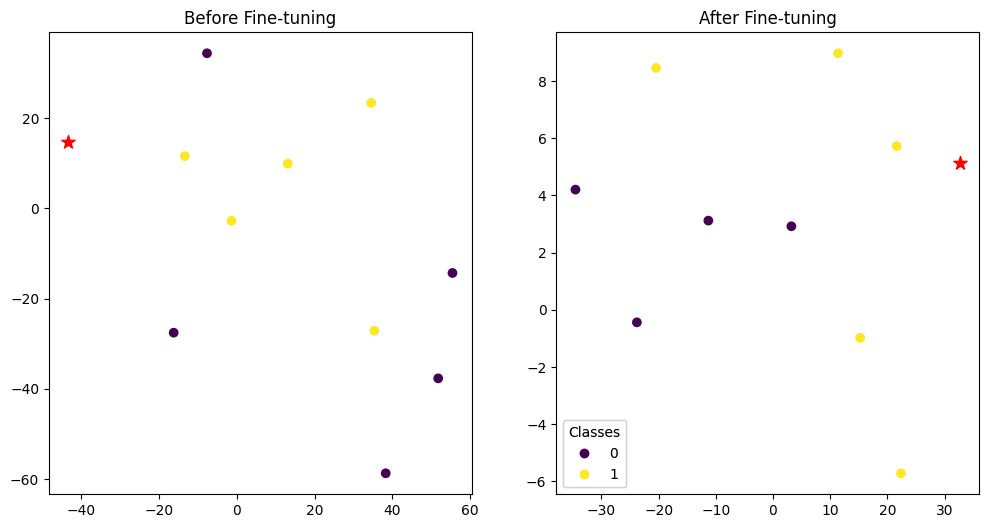

In [24]:
# Combine query and document embeddings (before fine-tuning)
all_embeddings_before = [query_embedding] + corpus_embeddings
# Combine query and document embeddings (after fine-tuning)
all_embeddings_after = [query_embedding_FT] + corpus_embeddings_FT

# Concatenate all embeddings and move them to CPU for further processing
all_embeddings_before_tensor = torch.cat(all_embeddings_before, dim=0).cpu()  # Concatenate and move to CPU
all_embeddings_after_tensor = torch.cat(all_embeddings_after, dim=0).cpu()  # Concatenate and move to CPU

# Create labels where 0 corresponds to the query, and the rest to documents
all_labels = [0] + example_labels  # Add a label for the query (e.g., 0)

# Apply t-SNE to reduce the dimensionality of embeddings to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_before_2d = tsne.fit_transform(all_embeddings_before_tensor.numpy())  # Embeddings before fine-tuning in 2D
embeddings_after_2d = tsne.fit_transform(all_embeddings_after_tensor.numpy())  # Embeddings after fine-tuning in 2D

# Extract query and document embeddings (before and after fine-tuning) for plotting
query_embedding_before_2d = embeddings_before_2d[0]  # Query embedding before fine-tuning
corpus_embeddings_before_2d = embeddings_before_2d[1:]  # Document embeddings before fine-tuning

query_embedding_after_2d = embeddings_after_2d[0]  # Query embedding after fine-tuning
corpus_embeddings_after_2d = embeddings_after_2d[1:]  # Document embeddings after fine-tuning

# Plot the embeddings before and after fine-tuning side by side
plt.figure(figsize=(12, 6))

# Plot for embeddings before fine-tuning
plt.subplot(1, 2, 1)
scatter = plt.scatter(corpus_embeddings_before_2d[:, 0], corpus_embeddings_before_2d[:, 1], c=example_labels, label='Documents')  # Plot documents
plt.scatter(query_embedding_before_2d[0], query_embedding_before_2d[1], c='red', marker='*', s=100, label='Query')  # Highlight the query embedding
plt.title('Before Fine-tuning')  # Add title

# Plot for embeddings after fine-tuning
plt.subplot(1, 2, 2)
scatter = plt.scatter(corpus_embeddings_after_2d[:, 0], corpus_embeddings_after_2d[:, 1], c=example_labels, label='Documents')  # Plot documents
plt.scatter(query_embedding_after_2d[0], query_embedding_after_2d[1], c='red', marker='*', s=100, label='Query')  # Highlight the query embedding
plt.title('After Fine-tuning')  # Add title

# Add a legend to show which colors correspond to which labels
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
plt.gca().add_artist(legend1)

# Display the plot
plt.show()

### ✏️ Observe the results above and discuss the following:
- According to the visualization, can you infer why fine-tuning leads to better IR results?
- What is t-SNE? What does it do?

Fine-tuning enhances IR performance by creating better separation between relevant and irrelevant documents in the embedding space. Relevant documents cluster closer to the query after fine-tuning, indicating the model has learned more discriminative representations for relevance.

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique. It projects high-dimensional data (like BERT embeddings) into a lower-dimensional space (like 2D for plotting) while aiming to preserve local relationships between data points. This allows for visualization of how the embeddings are distributed.

## 4.2 Visualizing The Attention

Let's use the following setence as example:

In [25]:
vis_sent = "I pulled another all-nighter trying to finish this project. Coffee has become my best friend."

### Visualizing Attention from Fine-Tuned BERT

In [26]:
# Input text for visualization
input_text = vis_sent

# Tokenize the input text
inputs = tokenizer.encode_plus(input_text, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
token_type_ids = inputs.get('token_type_ids')
attention_mask = inputs.get('attention_mask')

# Move inputs to the appropriate device (GPU if available)
input_ids = input_ids.to(device)
token_type_ids = token_type_ids.to(device) if token_type_ids is not None else None
attention_mask = attention_mask.to(device) if attention_mask is not None else None

# Get model outputs, ensuring to get attention weights
# The key change is here: output_attentions=True
outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, output_attentions=True)
attention = outputs.attentions  # Access attention weights from the outputs

# Get the tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Visualize attention
head_view(attention, tokens)

Output hidden; open in https://colab.research.google.com to view.

### Visualizing Attention from Pretrained BERT

Load the pretrained BERT again (`model` has now been fine-tuned)

In [27]:
model_pre = BertForSequenceClassification.from_pretrained(model_name, num_labels=2, output_hidden_states=True)  # Adjust num_labels as needed
model_pre.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [28]:
# Input text for visualization
input_text = vis_sent

# Tokenize the input text
inputs = tokenizer.encode_plus(input_text, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
token_type_ids = inputs.get('token_type_ids')
attention_mask = inputs.get('attention_mask')

# Move inputs to the appropriate device (GPU if available)
input_ids = input_ids.to(device)
token_type_ids = token_type_ids.to(device) if token_type_ids is not None else None
attention_mask = attention_mask.to(device) if attention_mask is not None else None

# Get model outputs, ensuring to get attention weights
# The key change is here: output_attentions=True
outputs = model_pre(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, output_attentions=True)
attention = outputs.attentions  # Access attention weights from the outputs

# Get the tokens for visualization
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Visualize attention
head_view(attention, tokens)

Output hidden; open in https://colab.research.google.com to view.

### ✏️ Observe the results above and discuss the following:
- How can we read this diagram?
- What are the words that contribute the most to the relevance classification tasl?
- How are the attention scores change after fine-tuning?

The attention diagram illustrates how different words "pay attention" to each other; stronger lines mean more important connections. Looking at different layers and heads shows different patterns.

To figure out which words are most important for relevance, we look at how much the [CLS] token (used for sentence tasks) attends to other words, especially in later layers. Words with high attention from [CLS] are key for the classification. In our examples, words like "all-nighter," "project," and "sleep deprivation" terms are likely important.

After fine-tuning, attention shifts. The model focuses more on words and phrases relevant to the task (finding relevant documents). This makes the fine-tuned model's attention more specialized for the task compared to the general pre-trained model.

# Assignment 2

## 1. Discussion Questions

Answer the discussion questions above (those with ✏️ icon).

## 2. Diving Deeper into Model Fine-Tuning Analysis

Refer to the following work that investigate BERT's behavior post fine-tuning:

```
    Yichu Zhou and Vivek Srikumar. 2022. A Closer Look at How Fine-tuning Changes BERT. In Proceedings of the 60th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers), pages 1046–1061, Dublin, Ireland. Association for Computational Linguistics.
```

In Section 4 Observations and Analysis, the authors show several obsevation on how fine-tuning changes BERT. Try to replicate their analysis in 4.1 to 4.3 and see if their discovery aligns with yours.<br />
You do not need to following everything step-by-step like using the exact same datasets or experiment setting. Focus on deriving similar insights.

In [29]:
# Replicating Zhou & Srikumar (2022) Sections 4.1–4.3 with our lab data
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Ensure datasets return PyTorch tensors for the required features
token_columns = ['input_ids', 'attention_mask']
if 'token_type_ids' in tokenized_dataset.features:
    token_columns.append('token_type_ids')

tokenized_dataset.set_format(type='torch', columns=token_columns + ['label'])
tokenized_eval_dataset.set_format(type='torch', columns=token_columns + ['label'])

def collect_model_outputs(model_ref, dataset):
    loader = DataLoader(dataset, batch_size=16)
    embeddings, logits, labels = [], [], []
    model_ref.eval()
    for batch in loader:
        labels.append(batch['label'].cpu().numpy())
        inputs = {k: batch[k].to(device) for k in token_columns if k in batch}
        with torch.no_grad():
            outputs = model_ref(**inputs, output_hidden_states=True)
        embeddings.append(outputs.hidden_states[-1][:, 0, :].cpu().numpy())
        logits.append(outputs.logits.cpu().numpy())
    embeddings = np.vstack(embeddings)
    logits = np.vstack(logits)
    labels = np.concatenate(labels)
    return embeddings, logits, labels

def spatial_similarity(emb_train, emb_eval):
    train_dist = pairwise_distances(emb_train, metric='cosine')
    eval_dist = pairwise_distances(emb_eval, metric='cosine')
    tri_train = train_dist[np.triu_indices(train_dist.shape[0], k=1)]
    tri_eval = eval_dist[np.triu_indices(eval_dist.shape[0], k=1)]
    min_len = min(len(tri_train), len(tri_eval))
    if min_len == 0:
        return float('nan')
    tri_train = np.sort(tri_train)[:min_len]
    tri_eval = np.sort(tri_eval)[:min_len]
    if np.std(tri_train) == 0 or np.std(tri_eval) == 0:
        return float('nan')
    return float(np.corrcoef(tri_train, tri_eval)[0, 1])

def centroid_stats(embeddings, labels):
    centroids, spreads = {}, {}
    for lbl in np.unique(labels):
        cluster = embeddings[labels == lbl]
        centroids[lbl] = cluster.mean(axis=0)
        spreads[lbl] = np.mean(np.linalg.norm(cluster - centroids[lbl], axis=1))
    pairwise = {}
    label_list = sorted(centroids.keys())
    for i in range(len(label_list)):
        for j in range(i + 1, len(label_list)):
            la, lb = label_list[i], label_list[j]
            pairwise[f"{la}-{lb}"] = float(np.linalg.norm(centroids[la] - centroids[lb]))
    return spreads, pairwise

# Collect embeddings, logits, and labels for pretrained and fine-tuned models
train_pre_emb, train_pre_logits, train_labels = collect_model_outputs(model_pre, tokenized_dataset)
eval_pre_emb, eval_pre_logits, eval_labels = collect_model_outputs(model_pre, tokenized_eval_dataset)
train_ft_emb, train_ft_logits, _ = collect_model_outputs(model, tokenized_dataset)
eval_ft_emb, eval_ft_logits, _ = collect_model_outputs(model, tokenized_eval_dataset)

# Section 4.1 style metrics
pre_train_acc = accuracy_score(train_labels, np.argmax(train_pre_logits, axis=1))
pre_eval_acc = accuracy_score(eval_labels, np.argmax(eval_pre_logits, axis=1))
ft_train_acc = accuracy_score(train_labels, np.argmax(train_ft_logits, axis=1))
ft_eval_acc = accuracy_score(eval_labels, np.argmax(eval_ft_logits, axis=1))
pre_similarity = spatial_similarity(train_pre_emb, eval_pre_emb)
ft_similarity = spatial_similarity(train_ft_emb, eval_ft_emb)

# Section 4.2 probes: linear (logistic) vs non-linear (MLP) heads
logreg_probe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, solver='liblinear'))
mlp_probe = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(128,), max_iter=1000, random_state=0))
logreg_pre_acc = logreg_probe.fit(train_pre_emb, train_labels).score(eval_pre_emb, eval_labels)
mlp_pre_acc = mlp_probe.fit(train_pre_emb, train_labels).score(eval_pre_emb, eval_labels)
logreg_ft_acc = logreg_probe.fit(train_ft_emb, train_labels).score(eval_ft_emb, eval_labels)
mlp_ft_acc = mlp_probe.fit(train_ft_emb, train_labels).score(eval_ft_emb, eval_labels)

# Section 4.3 geometry: intra- and inter-label distances
pre_spreads, pre_pairwise = centroid_stats(train_pre_emb, train_labels)
ft_spreads, ft_pairwise = centroid_stats(train_ft_emb, train_labels)

print("Section 4.1 – Accuracy and train/test similarity")
print(f"Pre-trained  – train acc: {pre_train_acc:.3f}, eval acc: {pre_eval_acc:.3f}, train/test similarity: {pre_similarity:.2f}")
print(f"Fine-tuned   – train acc: {ft_train_acc:.3f}, eval acc: {ft_eval_acc:.3f}, train/test similarity: {ft_similarity:.2f}\n")

print("Section 4.2 – Linear vs non-linear probes (eval accuracy)")
print(f"Pre-trained  – logistic: {logreg_pre_acc:.3f}, MLP: {mlp_pre_acc:.3f}")
print(f"Fine-tuned   – logistic: {logreg_ft_acc:.3f}, MLP: {mlp_ft_acc:.3f}\n")

print("Section 4.3 – Label geometry on training embeddings")
for lbl, spread in pre_spreads.items():
    print(f"Pre-trained  label {lbl} avg intra-cluster distance: {spread:.3f}")
for pair, dist in pre_pairwise.items():
    print(f"Pre-trained  centroid distance {pair}: {dist:.3f}")
print()
for lbl, spread in ft_spreads.items():
    print(f"Fine-tuned   label {lbl} avg intra-cluster distance: {spread:.3f}")
for pair, dist in ft_pairwise.items():
    print(f"Fine-tuned   centroid distance {pair}: {dist:.3f}")

Section 4.1 – Accuracy and train/test similarity
Pre-trained  – train acc: 0.433, eval acc: 0.350, train/test similarity: 0.92
Fine-tuned   – train acc: 1.000, eval acc: 1.000, train/test similarity: 0.90

Section 4.2 – Linear vs non-linear probes (eval accuracy)
Pre-trained  – logistic: 0.950, MLP: 0.950
Fine-tuned   – logistic: 1.000, MLP: 1.000

Section 4.3 – Label geometry on training embeddings
Pre-trained  label 0 avg intra-cluster distance: 5.139
Pre-trained  label 1 avg intra-cluster distance: 3.861
Pre-trained  centroid distance 0-1: 3.020

Fine-tuned   label 0 avg intra-cluster distance: 5.190
Fine-tuned   label 1 avg intra-cluster distance: 3.063
Fine-tuned   centroid distance 0-1: 29.239


## 💻 Assignment Submission 💻
Write your code and display the results in this Jupyter Notebook. Then, share this notebook and submit the link to this notebook to TronClass </br>
**Please ensure that the code is executed and the outputs are visible.**